In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras import backend

from model.data_loader import *
from model.unet_baseline import *
from model.unet_zhixuhao import *

## Data loader

In [31]:
train_pth = 'data/membrane/train'

data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

# why is batch size 2? paper says bs=1
train_gen = trainGenerator(2, train_pth, 'image', 'label', data_gen_args, save_to_dir=None)

# Fast test

## Compare baseline implementation to zhixuhao's model

It is observed that the final accuracy of both models varies in the range 80-96% when trained for 5 epochs with 2000 iterations. How can we quickly compare the performance of these two models?

Here's a quick comparison of models by training each for 50 iterations from scratch 30 times. We compare our baseline implementation to [zhixuhao's model](https://github.com/zhixuhao/unet) and find no significant difference.

In [81]:
def fast_test(model_fn, iterations, steps_per_iter, epochs=1, lr=1e-4):
    hists = []
    for i in range(iterations):
        model = model_fn()
        model.compile(optimizer = Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit_generator(train_gen, steps_per_epoch=steps_per_iter, epochs=1)
        hists.append(history.history)
#         r = {k: r[k][-1] for k in r}
#         df = df.append(r, ignore_index=True)
        backend.clear_session()
    return hists

def hists2df(hists:list):
    df = pd.DataFrame(columns=hists[0].keys())
    for h in hists:
        r = {k: h[k][-1] for k in h}
        df = df.append(r, ignore_index=True)
    return df

In [18]:
hists_zhixuhao = fast_test(unet_zhixuhao, 30, 50, epochs=1, lr=1e-4)
df_zhixuhao = hists2df(hists_zhixuhao)

Epoch 1/1
50/50 [==============================] - 12s 232ms/step - loss: 0.8322 - acc: 0.8077
Epoch 1/1
50/50 [==============================] - 12s 232ms/step - loss: 0.7661 - acc: 0.8168
Epoch 1/1
50/50 [==============================] - 12s 235ms/step - loss: 0.8373 - acc: 0.8045
Epoch 1/1
50/50 [==============================] - 11s 227ms/step - loss: 1.3986 - acc: 0.7481
Epoch 1/1
50/50 [==============================] - 12s 232ms/step - loss: 1.0304 - acc: 0.7696
Epoch 1/1
50/50 [==============================] - 12s 233ms/step - loss: 1.0034 - acc: 0.7668
Epoch 1/1
50/50 [==============================] - 12s 235ms/step - loss: 0.8602 - acc: 0.7770
Epoch 1/1
50/50 [==============================] - 12s 234ms/step - loss: 0.9069 - acc: 0.7997
Epoch 1/1
50/50 [==============================] - 11s 229ms/step - loss: 1.3861 - acc: 0.7665
Epoch 1/1
50/50 [==============================] - 12s 234ms/step - loss: 0.7629 - acc: 0.8170
Epoch 1/1
50/50 [==============================] -

In [34]:
hists_baseline = fast_test(unet_baseline, 30, 50, epochs=1, lr=1e-4)
df_baseline = hists2df(hists_baseline)

Epoch 1/1
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
50/50 [==============================] - 12s 241ms/step - loss: 1.0472 - acc: 0.7676
Epoch 1/1
50/50 [==============================] - 11s 230ms/step - loss: 0.9031 - acc: 0.7792
Epoch 1/1
50/50 [==============================] - 11s 227ms/step - loss: 1.3849 - acc: 0.7728
Epoch 1/1
50/50 [==============================] - 11s 228ms/step - loss: 0.8677 - acc: 0.7781
Epoch 1/1
50/50 [==============================] - 12s 233ms/step - loss: 0.9722 - acc: 0.7671
Epoch 1/1
50/50 [==============================] - 12s 233ms/step - loss: 1.3902 - acc: 0.7641
Epoch 1/1
50/50 [==============================] - 12s 238ms/step - loss: 0.9063 - acc: 0.7700
Epoch 1/1
50/50 [==============================] - 12s 242ms/step - loss: 1.4092 - acc: 0.7530
Epoch 1/1
50/50 [==============================] - 11s 230ms/step - loss: 0.9981 - acc: 0.7813
Epoch 1/1
50/50 [==============================] - 12s 230ms/step

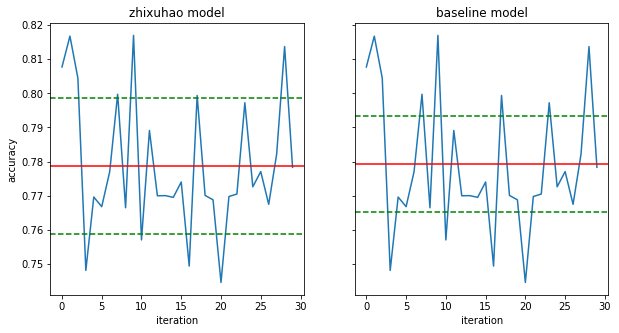

In [69]:
def stats(df):
    mean = df['acc'].mean()
    upper = mean + df['acc'].std()
    lower = mean - df['acc'].std()
    return mean, upper, lower

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

mean, upper, lower = stats(df_zhixuhao)
ax1.set_title('zhixuhao model')
ax1.plot(list(df_zhixuhao.index), list(df_zhixuhao['acc']))
ax1.axhline(y=mean, color='r')
ax1.axhline(y=upper, linestyle='--', color='g')
ax1.axhline(y=lower, linestyle='--', color='g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy')

mean, upper, lower = stats(df_baseline)
ax2.set_title('baseline model')
ax2.plot(list(df_baseline.index), list(df_zhixuhao['acc']))
ax2.axhline(y=mean, color='r')
ax2.axhline(y=upper, linestyle='--', color='g')
ax2.axhline(y=lower, linestyle='--', color='g')
ax2.set_xlabel('iteration');


# Slow test

In [ ]:
hists_zhixuhao_slow = fast_test(unet_zhixuhao, 10, 1000, epochs=1, lr=1e-4)
hists_baseline_slow = fast_test(unet_baseline, 10, 1000, epochs=1, lr=1e-4)

Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 1.3618 - acc: 0.7804
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5108 - acc: 0.8934
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5411 - acc: 0.8715
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.7130 - acc: 0.8497
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.4790 - acc: 0.8942
Epoch 1/1
1000/1000 [==============================] - 190s 190ms/step - loss: 0.5763 - acc: 0.8883
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5646 - acc: 0.8913
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5737 - acc: 0.8881
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5536 - acc: 0.8961
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5516 - acc: 0.8968
